### Ejercicio 1: Estimación del precio de coches usados

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [154]:
datos_train = pd.read_csv("dataset_coches_train.csv")

In [155]:
datos_train.describe(include = 'all')

,ID,marca,modelo,fecha,tipo_cambio,total_km,tipo_combustible,consumo,tipo_motor,tasa,precio
count,4960.000000,4960,4960,4960.000000,4812,4960.000000,4960,4564.000000,4960.000000,4960.000000,4960.000000
unique,NaN,9,90,NaN,4,NaN,5,NaN,NaN,NaN,NaN
top,NaN,merc,Arteon,NaN,Manual,NaN,Diesel,NaN,NaN,NaN,NaN
freq,NaN,790,167,NaN,1886,NaN,2989,NaN,NaN,NaN,NaN
mean,15832.446169,NaN,NaN,2016.737903,NaN,24956.286895,NaN,5.388508,2.124375,152.332661,23469.943750
std,2206.717006,NaN,NaN,2.884035,NaN,24443.333662,NaN,3.246347,0.789368,82.403844,16406.714563
min,12002.000000,NaN,NaN,1997.000000,NaN,1.000000,NaN,0.500000,0.000000,0.000000,450.000000
25%,13929.250000,NaN,NaN,2016.000000,NaN,5641.250000,NaN,4.330000,1.600000,145.000000,12000.000000
50%,15840.000000,NaN,NaN,2017.000000,NaN,19000.000000,NaN,4.990000,2.000000,145.000000,18999.000000
75%,17765.750000,NaN,NaN,2019.000000,NaN,36702.000000,NaN,6.080000,2.800000,150.000000,30335.750000


Vamos a responder la pregunta 1. Representamos gráficamente la distribución de la variable precio en el conjunto de entrenamiento

C:\Users\Pablo\AppData\Local\Temp\ipykernel_32696\2950953077.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()  # Muestra el cuadro con los nombres


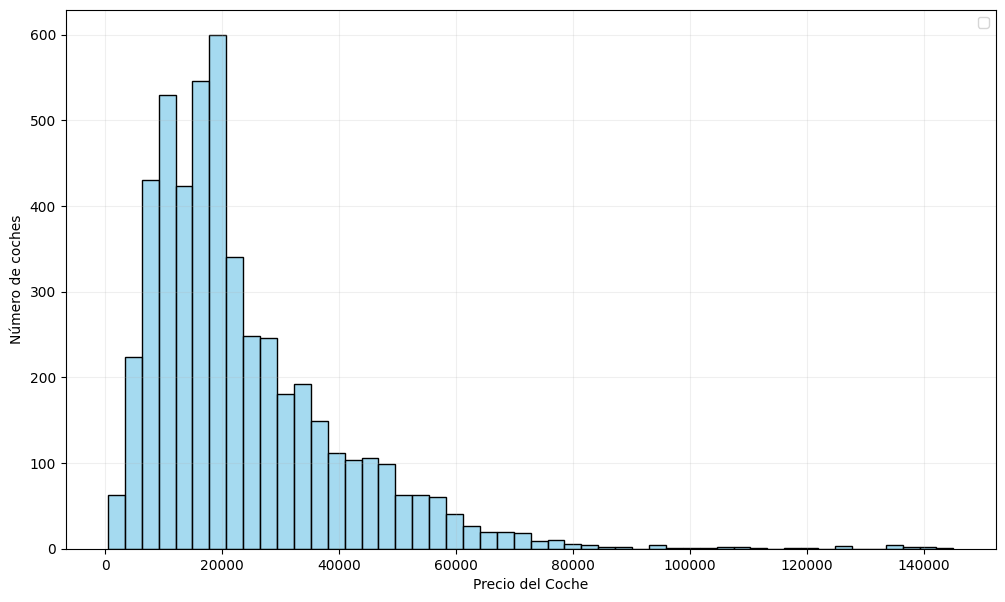

In [156]:
plt.figure(figsize=(12,7))
sns.histplot(datos_train["precio"], kde=False, stat="count", color='skyblue', bins=50)
plt.xlabel('Precio del Coche')
plt.ylabel('Número de coches')
plt.legend()  # Muestra el cuadro con los nombres
plt.grid(True, alpha=0.2)

plt.show()

Respondamos a la pregunta 2. Veamos cuál es la marca más cara en promedio y la más barata

In [157]:
precio_por_marca = datos_train.groupby('marca')['precio'].mean()

ranking = precio_por_marca.sort_values(ascending=False)

print(ranking)
print("\n")
print(f"Observamos que la marca más cara en promedio es {ranking.index[0]} con precio {ranking.iloc[0]:.2f}€ y la más barata {ranking.index[-1]} con precio {ranking.iloc[-1]:.2f}€")


marca
audi        42330.967930
bmw         37623.815047
merc        30308.413924
vw          21792.028646
toyota      18837.609865
ford        15927.887728
hyundi      14619.753425
skoda       13858.767059
vauxhall    11884.520147
Name: precio, dtype: float64


Observamos que la marca más cara en promedio es audi con precio 42330.97€ y la más barata vauxhall con precio 11884.52€


Respondamos ahora a la pregunta 3. Representamos gráficamente la dependencia entre el precio y la fecha

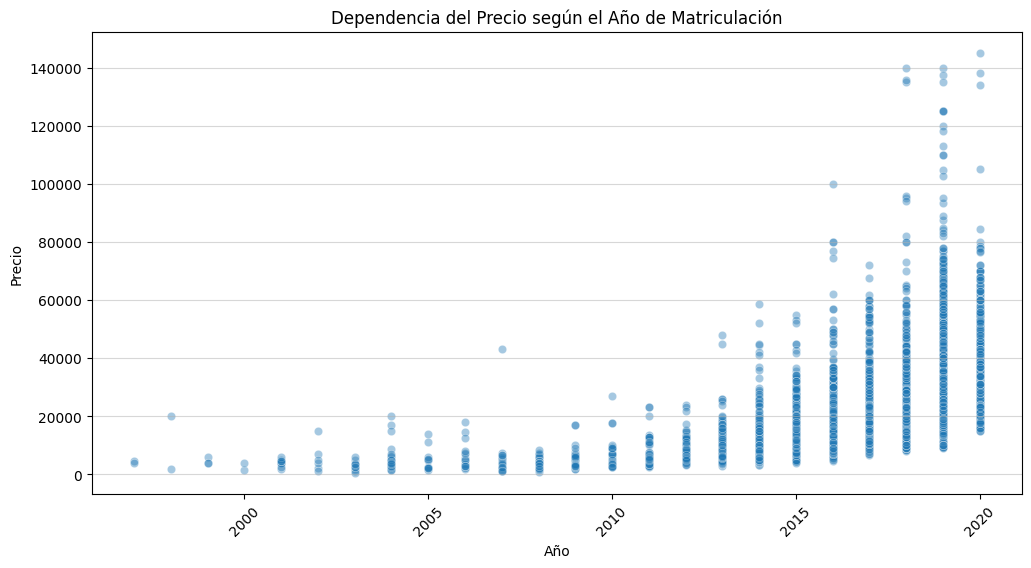

In [158]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=datos_train, x="fecha", y="precio", alpha=0.4)
plt.title('Dependencia del Precio según el Año de Matriculación')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=45) # Rotar años si se solapan

# Guardar o mostrar
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_32696\658534574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_train, x="fecha", y="precio", palette="viridis")


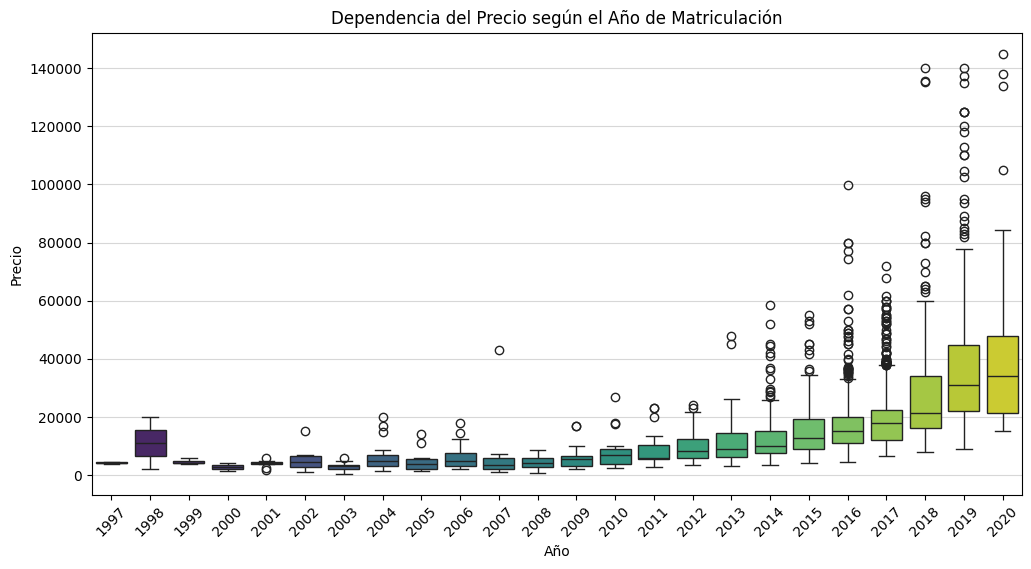

In [159]:
plt.figure(figsize=(12,6))
sns.boxplot(data=datos_train, x="fecha", y="precio", palette="viridis")
plt.title('Dependencia del Precio según el Año de Matriculación')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=45) # Rotar años si se solapan
plt.show()


Observamos una tendencia a subir el precio del vehículo a medida que aumenta el año de matriculación

La columna ID nos es irrelevante y vamos a eliminarla para evitar que el modelo aprenda relaciones en base al ID

In [160]:
datos_train = datos_train.drop(columns=["ID"])

Veamos si tenemos datos faltantes

In [161]:
datos_train.isnull().sum()


marca                 0
modelo                0
fecha                 0
tipo_cambio         148
total_km              0
tipo_combustible      0
consumo             396
tipo_motor            0
tasa                  0
precio                0
dtype: int64

Observamos que tenemos en los datos de entrenamiento 148 entradas faltantes del tipo de cambio de marcha y 396 del consumo. En los datos de test nos faltan 53 para el tipo de cambio y 26 del consumo. 

Para solucionar el problema de los datos faltantes vamos a sustituir estos "huecos" por la mediana del resto de datos sobre el consumo, y de forma aleatoria teniendo en cuenta la distribución de valores del tipo de cambio.

In [162]:
datos_train["tipo_cambio"].value_counts()


tipo_cambio
Manual       1886
Automatic    1615
Semi-Auto    1310
Other           1
Name: count, dtype: int64

Tenemos 4 tipos distintos de cambios, pero el valor Other solo aparece 1 única vez así que vamos a omitir esta valor para la asignación, así que asignaremos el valor Manual con una probabilidad de 1886/(1886+1615+1310) = 1886/4811 (approx) 0.39, el valor Automatic con 0.34 y el valor Semi-Auto con 0.27. Para ello vamos a fijar una semilla para hacer que el modelo sea el mismo en cualquier ordenador (no escoja diferentes valores cada vez que ejecutemos el codigo)

In [163]:
tipo_cambio_vacio = datos_train["tipo_cambio"].isnull()

rng = np.random.default_rng(seed=42)
relleno_tipos_cambio = rng.choice(["Manual", "Automatic", "Semi-Auto"], size=148, p=[0.39, 0.34, 0.27])

datos_train.loc[tipo_cambio_vacio, "tipo_cambio"] = relleno_tipos_cambio

In [164]:
datos_train["tipo_cambio"].value_counts()

tipo_cambio
Manual       1942
Automatic    1673
Semi-Auto    1344
Other           1
Name: count, dtype: int64

Ahora vamos a sustituir los huecos del consumo por la mediana del resto de datos.

In [165]:
datos_train["consumo"]=datos_train["consumo"].fillna(datos_train["consumo"].median())

In [166]:
datos_train.isnull().sum()

marca               0
modelo              0
fecha               0
tipo_cambio         0
total_km            0
tipo_combustible    0
consumo             0
tipo_motor          0
tasa                0
precio              0
dtype: int64

Ahora vamos a sustituir las variables categóricas por variables dummies, dropeando la primera columna que nos cree la función para evitar colinealidad

In [167]:
datos_train_procesado = pd.get_dummies(datos_train, columns=["tipo_cambio"], drop_first=True, dtype=int)
datos_train_procesado = pd.get_dummies(datos_train_procesado, columns=["marca"], drop_first=True, dtype=int) 
datos_train_procesado = pd.get_dummies(datos_train_procesado, columns=["tipo_combustible"], drop_first=True, dtype=int)
datos_train_procesado = pd.get_dummies(datos_train_procesado, columns=["modelo"], drop_first=True, dtype=int)

Y separamos el precio de los coches del resto de datos

In [168]:
X_datos_train = datos_train_procesado.drop(columns=["precio"])
y_datos_train = datos_train["precio"]

Vamos a responder a la pregunta 4 realizando un test estadístico para ver que variables son las más significativas. Para ello vamos a utilizar la información mutua, un test que mide la dependencia y detecta relaciones compleja entre las variables

In [169]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_datos_train,y_datos_train, random_state=42)

df_mi = pd.DataFrame({
    "Variable": X_datos_train.columns,
    "Mutual Info": mi_scores
}).sort_values("Mutual Info",ascending=False)

print("--- Ranking por Información Mutua ---")
print(df_mi.head(10))

--- Ranking por Información Mutua ---
                 Variable  Mutual Info
2                 consumo     0.606577
3              tipo_motor     0.600863
0                   fecha     0.427899
1                total_km     0.341447
4                    tasa     0.321223
5      tipo_cambio_Manual     0.214898
7   tipo_cambio_Semi-Auto     0.096991
8               marca_bmw     0.082246
9              marca_ford     0.070847
61              modelo_KA     0.060372


Observamos que las variables más significativas del modelo son el consumo y el tipo de motor (tiene sentido ya que son lo que más define la gama de un coche), siguiendo la fecha (ya que devalua el precio del coche a más antiguo), los kilómetros totales y la tasa del vehículo como los valores principales. También observamos que el tipo de cambio sea manual tiene bastante peso para ser una variable categórica, así que saber si el coche es manual o no, puede aportar buena información.

Ahora repitamos el proceso para los datos de testeo

In [170]:
datos_test = pd.read_csv("dataset_coches_test.csv")
datos_test = datos_test.drop(columns=["ID"])
datos_test.describe(include="all")



,marca,modelo,fecha,tipo_cambio,total_km,tipo_combustible,consumo,tipo_motor,tasa,precio
count,2672,2672,2672.000000,2619,2672.000000,2672,2646.000000,2672.000000,2672.000000,2672.000000
unique,9,89,NaN,4,NaN,5,NaN,NaN,NaN,NaN
top,ford,Santa Fe,NaN,Manual,NaN,Diesel,NaN,NaN,NaN,NaN
freq,430,95,NaN,971,NaN,1662,NaN,NaN,NaN,NaN
mean,NaN,NaN,2016.720434,NaN,24617.528443,NaN,5.409093,2.135105,153.261602,23784.075599
std,NaN,NaN,2.898906,NaN,23142.032992,NaN,3.041932,0.768596,80.742530,16600.736576
min,NaN,NaN,1970.000000,NaN,1.000000,NaN,0.500000,0.000000,0.000000,795.000000
25%,NaN,NaN,2016.000000,NaN,6000.000000,NaN,4.330000,1.600000,145.000000,12490.750000
50%,NaN,NaN,2017.000000,NaN,18548.000000,NaN,4.990000,2.000000,145.000000,19495.000000
75%,NaN,NaN,2019.000000,NaN,36272.250000,NaN,6.240000,2.800000,160.000000,30500.000000


In [171]:
datos_test.isnull().sum()

marca                0
modelo               0
fecha                0
tipo_cambio         53
total_km             0
tipo_combustible     0
consumo             26
tipo_motor           0
tasa                 0
precio               0
dtype: int64

Tenemos ahora 53 datos faltantes de tipo_cambio y 26 de consumo

In [172]:
datos_test["tipo_cambio"].value_counts()

tipo_cambio
Manual       971
Automatic    909
Semi-Auto    738
Other          1
Name: count, dtype: int64

In [173]:
tipo_cambio_vacio_test = datos_test["tipo_cambio"].isnull()

rng_test = np.random.default_rng(seed=42)
relleno_tipos_cambio_test = rng_test.choice(["Manual", "Automatic", "Semi-Auto"], size=53, p=[0.37, 0.35, 0.28])

datos_test.loc[tipo_cambio_vacio_test, "tipo_cambio"] = relleno_tipos_cambio_test

datos_test["consumo"]=datos_test["consumo"].fillna(datos_test["consumo"].median())

In [174]:
datos_test.isnull().sum()

marca               0
modelo              0
fecha               0
tipo_cambio         0
total_km            0
tipo_combustible    0
consumo             0
tipo_motor          0
tasa                0
precio              0
dtype: int64

In [175]:
datos_test_procesado = pd.get_dummies(datos_test, columns=["tipo_cambio"], drop_first=True, dtype=int)
datos_test_procesado = pd.get_dummies(datos_test_procesado, columns=["marca"], drop_first=True, dtype=int) 
datos_test_procesado = pd.get_dummies(datos_test_procesado, columns=["tipo_combustible"], drop_first=True, dtype=int)
datos_test_procesado = pd.get_dummies(datos_test_procesado, columns=["modelo"], drop_first=True, dtype=int)

X_datos_test = datos_test_procesado.drop(columns=["precio"])
y_datos_test = datos_test["precio"]

X_datos_test

,fecha,total_km,consumo,tipo_motor,tasa,tipo_cambio_Manual,tipo_cambio_Other,tipo_cambio_Semi-Auto,marca_bmw,marca_ford,...,modelo_X-CLASS,modelo_X4,modelo_X6,modelo_X7,modelo_Yeti,modelo_Z3,modelo_Z4,modelo_Zafira Tourer,modelo_i3,modelo_i8
0,2017,12046,6.32,3.0,150.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,37683,6.50,3.0,260.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019,10000,6.92,3.0,145.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019,3257,4.74,1.0,145.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,20982,8.00,4.0,325.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2015,21100,7.92,4.0,325.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2668,2015,60972,4.50,3.0,160.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2669,2020,4111,4.67,1.0,145.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2670,2016,25726,5.67,2.0,200.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ya tenemos los datos preparados para entrenar el modelo

Vamos a crear un modelo de arboles de decisión para estimar el precio de venta de un coche utilizando todo el conjunto de datos que tenemos disponible

In [176]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [177]:
arbol = DecisionTreeRegressor(random_state=42, max_depth=9)

arbol.fit(X_datos_train, y_datos_train)

# ...y los evaluamos en el conjunto de test
print('Regresión')
print('-'*10)

predicciones = arbol.predict(X_datos_test)

mae_test = mean_absolute_error(y_datos_test, predicciones)

print('MAE en test: %.3f' % mae_test)
print('')



Regresión
----------


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- modelo_M6


Nos salta el siguiente error: ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- modelo_M6


Esto se debe a que al separar el conjunto de datos train del test, ha dado la casualidad de que en el conjunto de train había un coche de modelo m6 pero en el conjunto train no lo ha habido. A la hora de crear las variables dummmies no se ha tenido en cuenta para el conjunto de test y por eso falla. Para ello vamos a incluir en el conjunto test una columna de modelo_m6 con valor 0

In [178]:
X_datos_test = X_datos_test.reindex(columns=X_datos_train.columns, fill_value=0)

In [183]:
for i in range(1,81):

    arbol_1 = DecisionTreeRegressor(random_state=42, max_depth=i)

    arbol_1.fit(X_datos_train, y_datos_train)
    print(f'Regresión de profundidad {i}')
    print('-'*50)

    predicciones = arbol_1.predict(X_datos_test)

    mae_test = mean_absolute_error(y_datos_test, predicciones)

    print('MAE en test: %.3f' % mae_test)
    print('')

Regresión de profundidad 1
--------------------------------------------------
MAE en test: 9356.144

Regresión de profundidad 2
--------------------------------------------------
MAE en test: 7344.724

Regresión de profundidad 3
--------------------------------------------------
MAE en test: 6002.550

Regresión de profundidad 4
--------------------------------------------------
MAE en test: 5162.692

Regresión de profundidad 5
--------------------------------------------------
MAE en test: 4529.693

Regresión de profundidad 6
--------------------------------------------------
MAE en test: 4040.342

Regresión de profundidad 7
--------------------------------------------------
MAE en test: 3615.238

Regresión de profundidad 8
--------------------------------------------------
MAE en test: 3219.650

Regresión de profundidad 9
--------------------------------------------------
MAE en test: 3062.698

Regresión de profundidad 10
--------------------------------------------------
MAE en test:

Obtenemos un MAE superior a lo permitido, vamos a intentar afinarlo eliminando variables del conjunto de datos. Vamos a quedarnos únicamente con las variables "consumo", "tipo_motor", "fecha", "total_km", "tasa", "tipo_cambio_Manual" . Vamos a eliminar la variable modelo

In [ ]:
datos_test_procesado_1 = pd.get_dummies(datos_test, columns=["tipo_cambio"], drop_first=True, dtype=int)
datos_test_procesado_1 = pd.get_dummies(datos_test_procesado_1, columns=["marca"], drop_first=True, dtype=int) 
datos_test_procesado_1 = pd.get_dummies(datos_test_procesado_1, columns=["tipo_combustible"], drop_first=True, dtype=int)
X_datos_test_1 = datos_test_procesado_1.drop(columns=["precio"])
X_datos_test_1 = X_datos_test_1.drop(columns=["modelo"])


datos_train_procesado_1 = pd.get_dummies(datos_train, columns=["tipo_cambio"], drop_first=True, dtype=int)
datos_train_procesado_1 = pd.get_dummies(datos_train_procesado_1, columns=["marca"], drop_first=True, dtype=int) 
datos_train_procesado_1 = pd.get_dummies(datos_train_procesado_1, columns=["tipo_combustible"], drop_first=True, dtype=int)


X_datos_train_1 = datos_train_procesado_1.drop(columns=["precio"])
X_datos_train_1 = X_datos_train_1.drop(columns=["modelo"])

X_datos_test_1

,fecha,total_km,consumo,tipo_motor,tasa,tipo_cambio_Manual,tipo_cambio_Other,tipo_cambio_Semi-Auto,marca_bmw,marca_ford,marca_hyundi,marca_merc,marca_skoda,marca_toyota,marca_vauxhall,marca_vw,tipo_combustible_Electric,tipo_combustible_Hybrid,tipo_combustible_Other,tipo_combustible_Petrol
0,2017,12046,6.32,3.0,150.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2017,37683,6.50,3.0,260.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2019,10000,6.92,3.0,145.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2019,3257,4.74,1.0,145.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,2015,20982,8.00,4.0,325.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2015,21100,7.92,4.0,325.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2668,2015,60972,4.50,3.0,160.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2669,2020,4111,4.67,1.0,145.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2670,2016,25726,5.67,2.0,200.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
X_datos_train_1 = X_datos_train[["consumo","tipo_motor","fecha","total_km","tasa","tipo_cambio_Manual"]].copy()
X_datos_test_1 = X_datos_test[["consumo","tipo_motor","fecha","total_km","tasa","tipo_cambio_Manual"]].copy()

In [ ]:
for i in range(1,21):

    arbol_1 = DecisionTreeRegressor(random_state=42, max_depth=i)

    arbol_1.fit(X_datos_train_1, y_datos_train)

    # ...y los evaluamos en el conjunto de test
    print(f'Regresión profundidad {i}')
    print('-'*50)

    predicciones_1 = arbol_1.predict(X_datos_test_1)

    mae_test_1 = mean_absolute_error(y_datos_test, predicciones_1)

    print('MAE en test: %.3f' % mae_test_1)
    print('\n')

Regresión profundidad 1
--------------------------------------------------
MAE en test: 9356.144


Regresión profundidad 2
--------------------------------------------------
MAE en test: 7344.724


Regresión profundidad 3
--------------------------------------------------
MAE en test: 6002.550


Regresión profundidad 4
--------------------------------------------------
MAE en test: 5211.970


Regresión profundidad 5
--------------------------------------------------
MAE en test: 4574.461


Regresión profundidad 6
--------------------------------------------------
MAE en test: 4091.571


Regresión profundidad 7
--------------------------------------------------
MAE en test: 3726.498


Regresión profundidad 8
--------------------------------------------------
MAE en test: 3395.329


Regresión profundidad 9
--------------------------------------------------
MAE en test: 3189.221


Regresión profundidad 10
--------------------------------------------------
MAE en test: 2964.237


Regresión

Nos quedamos con el modelo de profundidad 12 con ya que encontramos el óptimo y evitamos overfitting.

# Modelo Final

In [ ]:
modelo_tasacion = DecisionTreeRegressor(random_state=42, max_depth=12)
modelo_tasacion.fit(X_datos_train_1, y_datos_train)

DecisionTreeRegressor(max_depth=12, random_state=42)

Respondamos ahora a la pregunta número 5: ¿a cuanto deberíamos vender un audi A7 de 2020 con 5000 km, cambio automático, combustible híbrido, consumo de 5.5l/100km y motor 4.0, con tasa de circulación de 200€?

In [ ]:
coche = {
    'marca': 'audi',
    'modelo': 'A7',
    'fecha': 2020,
    'total_km': 5000,
    'tipo_cambio': 'Automatic',
    'tipo_combustible': 'Hybrid',  
    'consumo': 5.5,
    'tipo_motor': 4.0,
    'tasa': 200
}

df_coche = pd.DataFrame([coche])

df_coche_procesado = pd.get_dummies(df_coche, dtype=int)

df_coche_procesado = df_coche_procesado.reindex(columns=X_datos_train_1.columns, fill_value=0)

df_coche_procesado

precio_estimado = modelo_tasacion.predict(df_coche_procesado)

print(f"El precio estimado para este Audi A7 es: {precio_estimado[0]:.2f}€")


El precio estimado para este Audi A7 es: 84496.00€


duda = ¿No son demasiadas columnas?
¿habria que hacer regresion antes para ver que variables no son tan importantes?
duda = en el tipo de cambio solo hay una entrada con el valor otros (lo cambio o lo destruyo?)
¿a la hora de cambiar 
problema: el modelo no sirve para modelos de coches nuevos